In [15]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import plot_dependence_heatmap, feature_dependence_matrix

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import optuna

import dill

%matplotlib inline

In [2]:
RAND_STATE = 1977

In [3]:
data = pd.read_csv("heart.csv")

## Do some EDA

In [6]:
profile_report = ProfileReport(data, title="Heart Disease profiling Report", explorative=True)

In [17]:
profile_report.config.variables.descriptions = {
    "age": "age in years",
    "sex": "1 = male; 0 = female",
    "cp": "chest pain type",
    "trestbps": "resting blood pressure (in mm Hg on admission to the hospital)",
    "chol": "serum cholestoral in mg/dl) - (needs to be less than 200 mg/dL)",
    "fbs": "fasting blood sugar > 120 mg/dl (1 = true; 0 = false) - (A fasting blood sugar level less than 100 mg/dL (5.6 mmol/L) is normal. A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes.",
    "restecg": "resting electrocardiographic results",
    "thalach": "maximum heart rate achieved",
    "exang": "exercise induced angina (1 = yes; 0 = no) - (Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood.)",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "the slope of the peak exercise ST segment",
    "ca": "number of major vessels (0-3) colored by flourosopy",
    "thal": "3 = normal; 6 = fixed defect; 7 = reversable defect",
    "target": "Value 0: < 50% diameter narrowing - Value 1: > 50% diameter narrowing"
}

### HTML report

In [8]:
profile_report.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


### Correlation plot

<AxesSubplot:>

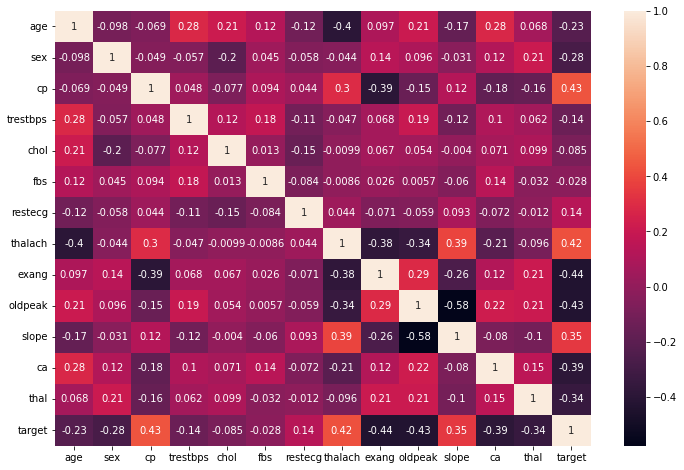

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True)

### Pair grid

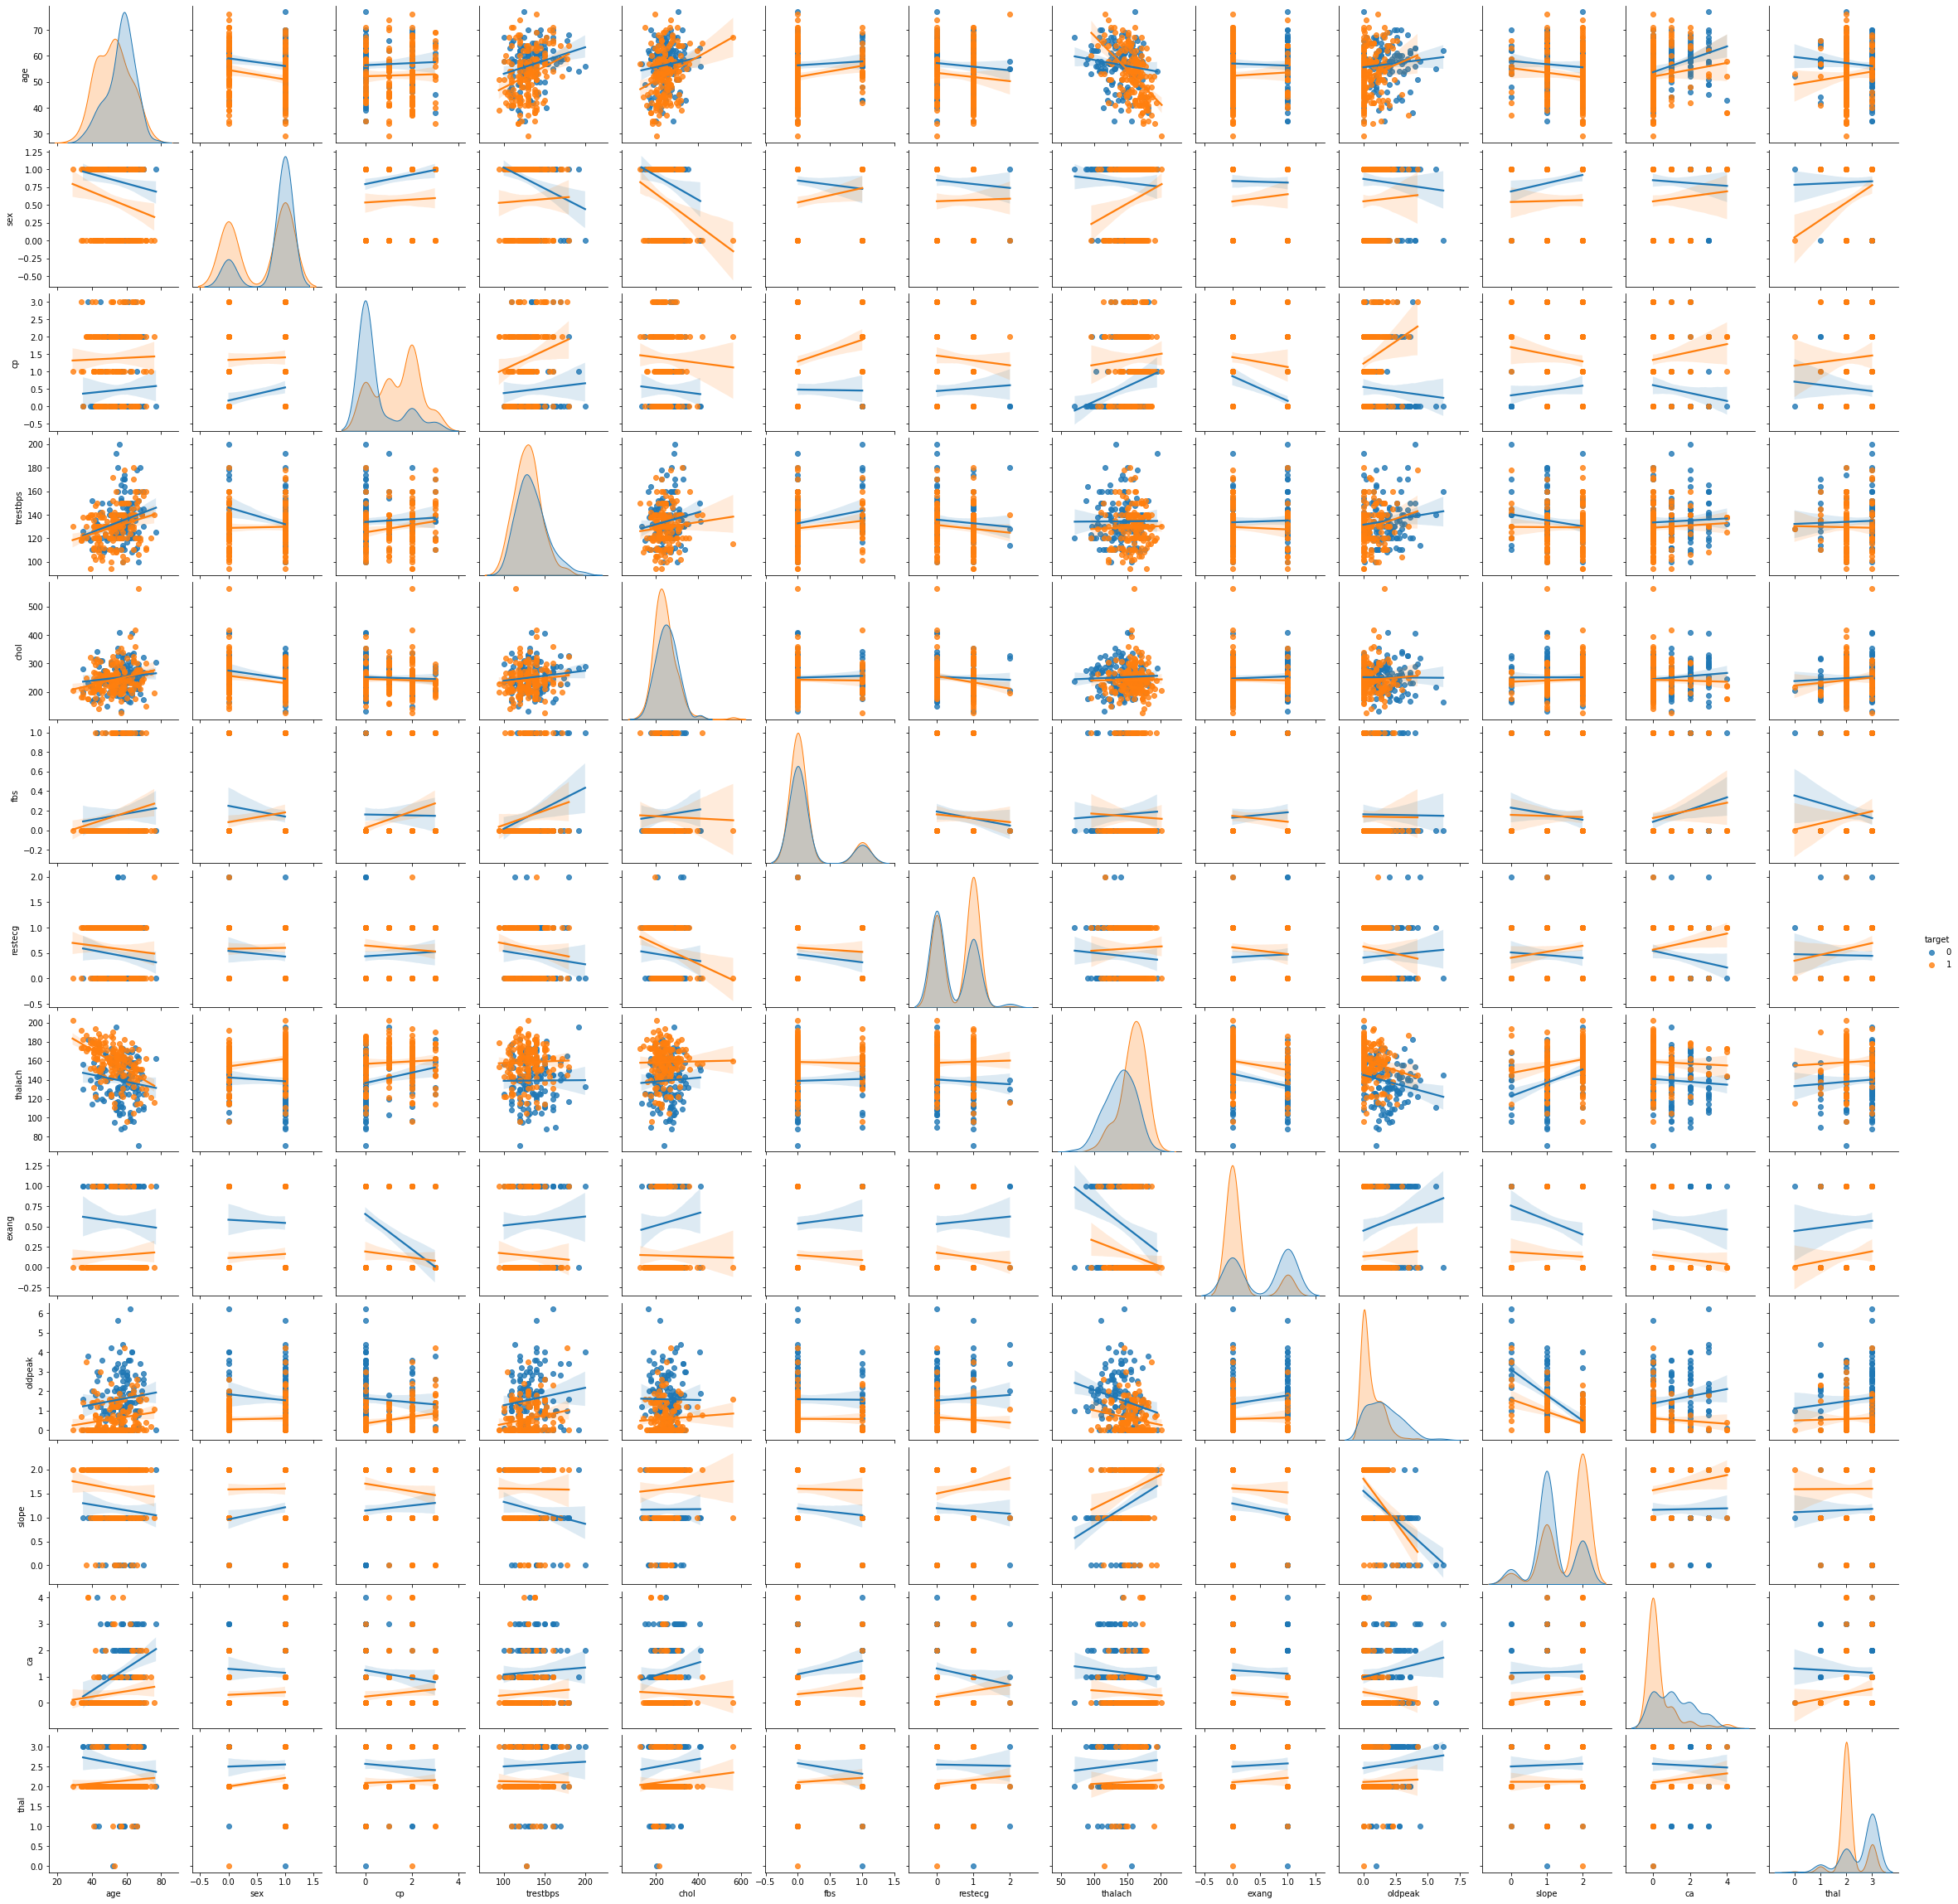

In [10]:
#fig, ax = p
sns.pairplot(data, hue="target", kind="reg")

## Prepping data

In [4]:
print(f"data: {data.shape}")

data: (303, 14)


In [5]:
X = data.drop("target", axis=1)
y = data["target"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1)

In [7]:
print(f"X train: {X_train.shape}, y train: {y_train.shape}")

X train: (272, 13), y train: (272,)


## Do hyperparameters tuning

### Feature selection

f:\www\py-proj\otus\ml-api\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
f:\www\py-proj\otus\ml-api\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
f:\www\py-proj\otus\ml-api\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
f:\www\py-proj\otus\ml-api\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
f:\www\py-proj\otus\ml-api\env\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
f:\www\py-proj\otus\ml-api\env\li

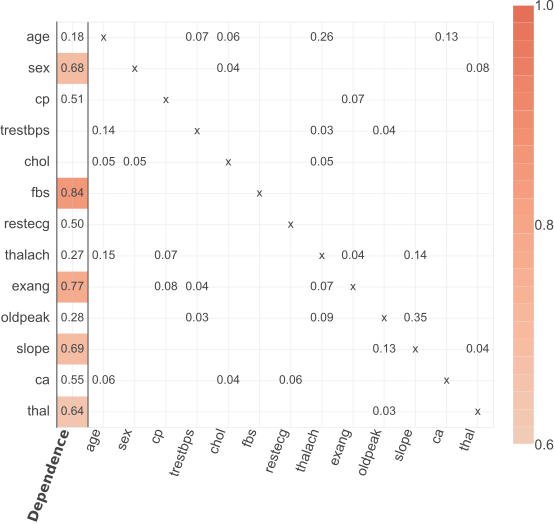

In [213]:
# Check correlations

plot_dependence_heatmap(
    feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
    
)

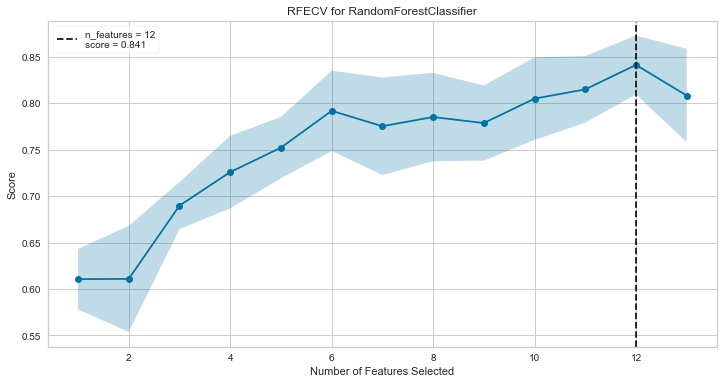

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [175]:
# Recursive feature elimination
from yellowbrick.features import RFECV
from sklearn.ensemble import RandomForestClassifier

fig, ax = plt.subplots(figsize=(12, 6))

rfe = RFECV(
    RandomForestClassifier(n_estimators=100), cv=5)

rfe.fit(X, y)
rfe.show()

In [176]:
rfe.rfe_estimator_.ranking_

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [177]:
rfe.rfe_estimator_.n_features_

12

In [178]:
X_train.columns[~rfe.rfe_estimator_.support_]

Index(['fbs'], dtype='object')

<AxesSubplot:ylabel='feature'>

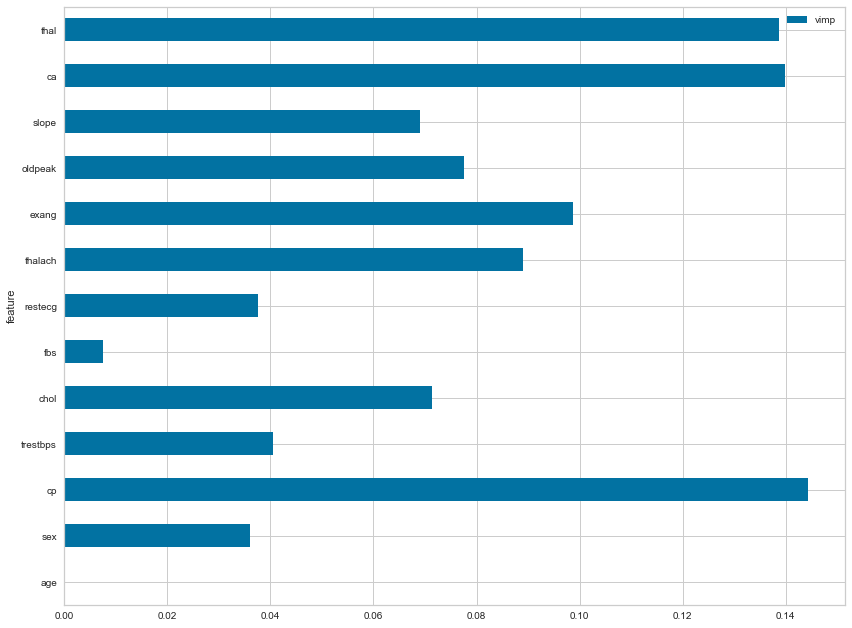

In [45]:
# Mutual information

from sklearn.feature_selection  import mutual_info_classif

mut_inf = mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(14, 11))

(
    pd.DataFrame({"feature": X.columns, "vimp": mut_inf})
        .set_index("feature")
        .plot.barh(ax=ax)
)

In [46]:
mut_inf

array([0.        , 0.0361499 , 0.14431246, 0.04052843, 0.07141505,
       0.00753365, 0.03760661, 0.0890562 , 0.09880203, 0.07750693,
       0.06906155, 0.13986808, 0.13868606])

#### Select k-best

In [66]:
from sklearn.feature_selection import SelectKBest, chi2

feature_sel = SelectKBest(chi2, k=10).fit(X, y)
set(X.columns).difference(feature_sel.get_feature_names_out())
#feature_sel.get_feature_names_out()

{'fbs', 'restecg', 'thal'}

#### Permutation feature importances

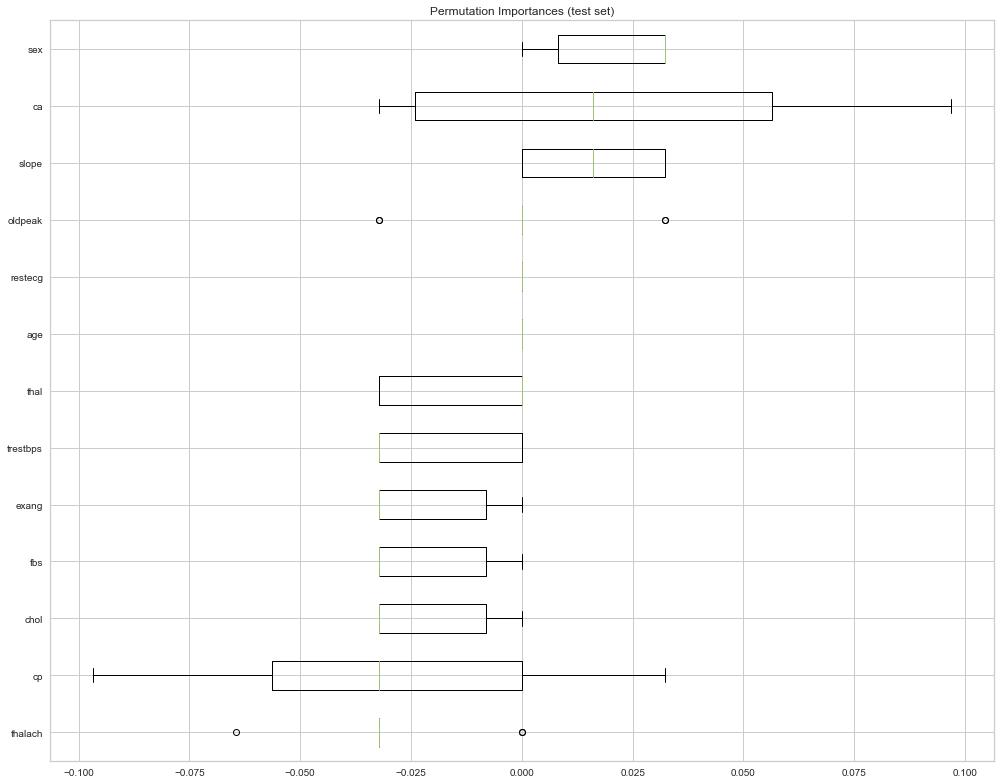

In [235]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    RandomForestClassifier(random_state=RAND_STATE).fit(X_train, y_train), X_val, y_val, n_repeats=10, random_state=RAND_STATE, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14, 11))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_val.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Random forest & Gradient Boosting

In [107]:
from sklearn.ensemble import RandomForestClassifier

X_train_rf = X_train.drop(["fbs"], axis=1)
X_val_rf = X_val.drop(["fbs"], axis=1)

rf = RandomForestClassifier().fit(X_train_rf, y_train)

preds_rf = rf.predict(X_val_rf)

print(f"accuracy: {accuracy_score(y_val, preds_rf):.3f}, F1: {f1_score(y_val, preds_rf):.3f}, recall: {recall_score(y_val, preds_rf):.3f}")

accuracy: 0.871, F1: 0.889, recall: 0.941


In [8]:
from sklearn.ensemble import GradientBoostingClassifier

X_train_gb = X_train.drop(["fbs"], axis=1)
X_val_gb = X_val.drop(["fbs"], axis=1)

params_gb = {'loss': 'exponential', 'learning_rate': 0.01717893873515427, 'n_estimators': 90, 'subsample': 0.25620977687426155, 'criterion': 'squared_error'}
#params_gb = {"n_estimators": 40, "max_depth": 2}
#params_gb = {}
#gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01).fit(X_train_gb, y_train)
gb = GradientBoostingClassifier(**params_gb, random_state=RAND_STATE).fit(X_train_gb, y_train)

skf_gb = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE)

preds_gb = gb.predict(X_val_gb)
scores_gb = cross_val_score(gb, X, y, scoring="f1", cv=skf_gb, n_jobs=-1)

print(f"accuracy: {accuracy_score(y_val, preds_gb):.3f}, F1: {f1_score(y_val, preds_gb):.3f}, precision: {precision_score(y_val, preds_gb):.3f}, recall: {recall_score(y_val, preds_gb):.3f}, cross val: {scores_gb.mean():.3f}")



accuracy: 0.903, F1: 0.909, precision: 0.938, recall: 0.882, cross val: 0.850


In [18]:
# save model to file

with open("heart_model.pkl", "wb") as f:
    dill.dump(gb, f)

In [153]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 70,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### Optimize Gradient Boossting with Optuna

In [236]:
skf_gbc = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE)
X_train_optuna_gbc = X_train.drop(["fbs", "exang"], axis=1)
X_val_optuna_gbc = X_val.drop(["fbs", "exang"], axis=1)


def objective_gbc(trial):
    loss = trial.suggest_categorical("loss", ["deviance", "exponential"])
    learn_rate = trial.suggest_float("learning_rate", 1e-3, 5e-1)
    n_est = trial.suggest_int("n_estimators", 50, 500)
    subsample = trial.suggest_float("subsample", 0.1, 1)
    criterion = trial.suggest_categorical("criterion", ["friedman_mse", "squared_error", "mse", "mae"])

    clf = GradientBoostingClassifier(loss=loss, learning_rate=learn_rate, n_estimators=n_est, subsample=subsample, criterion=criterion, random_state=RAND_STATE)

    scores = cross_val_score(clf, X_train_optuna_gbc, y_train, n_jobs=-1, cv=skf_gbc, scoring="f1", )

    return scores.mean()

In [238]:
study_gbc = optuna.create_study(direction="maximize")
study_gbc.optimize(objective_gbc, n_trials=1000)

[I 2021-11-17 23:54:54,787] A new study created in memory with name: no-name-80489eee-8a51-4b69-a416-9a5c41afd7df
[I 2021-11-17 23:54:55,068] Trial 0 finished with value: 0.7850652959155321 and parameters: {'loss': 'exponential', 'learning_rate': 0.3631189391326427, 'n_estimators': 226, 'subsample': 0.35672708857845836, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.7850652959155321.
[I 2021-11-17 23:54:55,635] Trial 1 finished with value: 0.6060755813953488 and parameters: {'loss': 'deviance', 'learning_rate': 0.14929866409259082, 'n_estimators': 358, 'subsample': 0.17106084796534077, 'criterion': 'mae'}. Best is trial 0 with value: 0.7850652959155321.
[I 2021-11-17 23:54:56,052] Trial 2 finished with value: 0.4096386630532972 and parameters: {'loss': 'deviance', 'learning_rate': 0.3241211255639105, 'n_estimators': 408, 'subsample': 0.2647294886828435, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.7850652959155321.
[I 2021-11-17 23:54:56,383] Trial 3 finish

In [239]:
print(f"best params: {study_gbc.best_params}")

best params: {'loss': 'exponential', 'learning_rate': 0.02647080801787518, 'n_estimators': 151, 'subsample': 0.2970125674371562, 'criterion': 'friedman_mse'}


### Optimize with Optuna

In [93]:
def objective_sgd(trial):
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge", "modified_huber", "log"])
    learn_rate = trial.suggest_categorical("learning_rate", ["optimal", "adaptive"])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2)
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    eta0 = trial.suggest_float("eta0", 1e-6, 1e-2)

    # if penalty == "elasticnet":
    #     l1_ratio = trial.suggest_float(0, 1)
    # else:
    #     l1_ratio = None

    clf = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, learning_rate=learn_rate, eta0=eta0)

    scores = cross_val_score(clf, X, y, n_jobs=-1, cv=5, scoring="f1")

    return scores.mean()

In [94]:
study_sgd = optuna.create_study(direction="maximize")
study_sgd.optimize(objective_sgd, n_trials=5000)

[I 2021-10-29 23:17:37,812] A new study created in memory with name: no-name-3d1c28ce-176d-49cb-9963-c3f82db85c78
[I 2021-10-29 23:17:37,842] Trial 0 finished with value: 0.6974550498797608 and parameters: {'loss': 'hinge', 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'alpha': 0.0053507156789081144, 'l1_ratio': 0.6149027926358485, 'eta0': 0.008818806651450045}. Best is trial 0 with value: 0.6974550498797608.
[I 2021-10-29 23:17:37,916] Trial 1 finished with value: 0.8281927490095887 and parameters: {'loss': 'log', 'learning_rate': 'adaptive', 'penalty': 'elasticnet', 'alpha': 0.007476335895256647, 'l1_ratio': 0.06889414976521946, 'eta0': 0.005416053891473046}. Best is trial 1 with value: 0.8281927490095887.
[I 2021-10-29 23:17:37,955] Trial 2 finished with value: 0.6038187668284195 and parameters: {'loss': 'squared_hinge', 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'alpha': 0.006124523907995644, 'l1_ratio': 0.14458979531789995, 'eta0': 0.006788484233388612}. Best is t

In [95]:
print(f"best score: {study.best_value}")

best score: 0.8706807093302537


In [96]:
print(f"best params: {study.best_params}")

best params: {'loss': 'log', 'learning_rate': 'adaptive', 'penalty': 'l1', 'alpha': 0.004890673189485255, 'l1_ratio': 0.4065517710232452, 'eta0': 0.0019366396018313703}


### Eval feature importances with LightGBM

In [66]:
import lightgbm as lgbm

In [67]:
lgbm_pipe = make_pipeline(StandardScaler(), lgbm.LGBMClassifier())

lgbm_clf = lgbm_pipe.fit(X_train, y_train)

In [68]:
feature_importances = lgbm_clf.named_steps["lgbmclassifier"].feature_importances_

In [69]:
y_pred_all = lgbm_clf.predict(X)

print(f"f1: {f1_score(y, y_pred_all):.3f}, recall: {recall_score(y, y_pred_all):.3f}, accuracy: {accuracy_score(y, y_pred_all):.3f}")

f1: 0.973, recall: 0.988, accuracy: 0.970


In [70]:
y_pred_val = lgbm_clf.predict(X_val)

print(f"f1: {f1_score(y_val, y_pred_val):.3f}, recall: {recall_score(y_val, y_pred_val):.3f}, accuracy: {accuracy_score(y_val, y_pred_val):.3f}")

f1: 0.789, recall: 0.882, accuracy: 0.742


In [73]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

scores = cross_val_score(lgbm_clf, X, y, cv=kf, scoring="f1", n_jobs=-1)

In [75]:
scores.mean()
    

0.8101878019408979